# Visualizing Geographic Data Distributions in the United States

### Assumptions

- Since actual 2020 data wasn't provided, simulated random data was used

- Tornado magnitudes were randomly assigned with EF0 being most common

- Points were constrained to land areas within state boundaries

- Coordinate reference system was consistent (WGS84)

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize

# Load county subdivisions shapefile
shapefile = 'cb_2020_us_cousub_500k/cb_2020_us_cousub_500k.shp'
subdivisions = gpd.read_file(shapefile)

# Filter to contiguous 48 states
# Exclude Alaska, Hawaii, and territories
exclude_states = ['AK', 'HI', 'PR', 'VI', 'MP', 'GU', 'AS']
contig_subs = subdivisions[~subdivisions['STUSPS'].isin(exclude_states)].copy()

# Dissolve subdivisions into state boundaries
# Geometries aggregated by USPS code
states = contig_subs.dissolve(by='STUSPS', as_index=False)

# Merge state names
name_lookup = contig_subs[['STUSPS', 'NAME']].drop_duplicates()
states = states.merge(name_lookup, on='STUSPS', how='left')

# Project to equal-area CRS for accurate area calculation
states = states.to_crs(epsg=5070)

# Compute state area in square kilometers
states['area_sqkm'] = states['geometry'].area / 1e6

# Determine bounding box for uniform sampling
minx, miny, maxx, maxy = states.total_bounds

num_tornadoes = 5000

# Generate random tornado locations within bounding box
lons = np.random.uniform(minx, maxx, num_tornadoes)
lats = np.random.uniform(miny, maxy, num_tornadoes)

# Random EF-scale magnitudes 0-4
magnitudes = np.random.randint(0, 5, num_tornadoes)

# Create GeoDataFrame of tornado points
tornadoes = gpd.GeoDataFrame(
    {'magnitude': magnitudes},
    geometry=gpd.points_from_xy(lons, lats),
    crs=states.crs
)
# Compute union of all state geometries to filter points
union_geom = states.geometry.union_all()

# Keep only points that fall within the union of state polygons
tornadoes = tornadoes[tornadoes.within(union_geom)]

# Assign random dates in 2020 to tornadoes for temporal plots
dates = pd.date_range(start='2020-01-01', end='2020-12-31', periods=len(tornadoes))
tornadoes['month'] = dates.month

## Spatial join to count tornadoes in each state
joined = gpd.sjoin(tornadoes, states, how='inner', predicate='within')

# Count tornadoes per state code
counts = joined['STUSPS'].value_counts()

# Map counts back to states, fill missing with zero
states['tornado_count'] = states['STUSPS'].map(counts).fillna(0).astype(int)


# Compute density per square kilometer
states['tornado_per_sqkm'] = states['tornado_count'] / states['area_sqkm']


# Base Map of the United States

**Purpose and Rationale**  
The base map serves as the foundational geographic context for all subsequent visualizations. It establishes the spatial framework of the contiguous 48 states.

**Big Takeaway**  
This clean reference map enables proper interpretation of spatial patterns in tornado distribution data.

**What the Visualization Shows**  
- Boundaries of all 48 contiguous US states  
- State abbreviations for orientation  
- Geographic relationships between states  

**Highlight**  
Minimalist design balances clarity with necessary geographic context.

**Key Insights**  
- Helps viewers orient tornado patterns within geographic space  
- Provides reference for subsequent visualizations  

**Why This Matters**  
Spatial analysis requires accurate geographic context to draw meaningful conclusions.


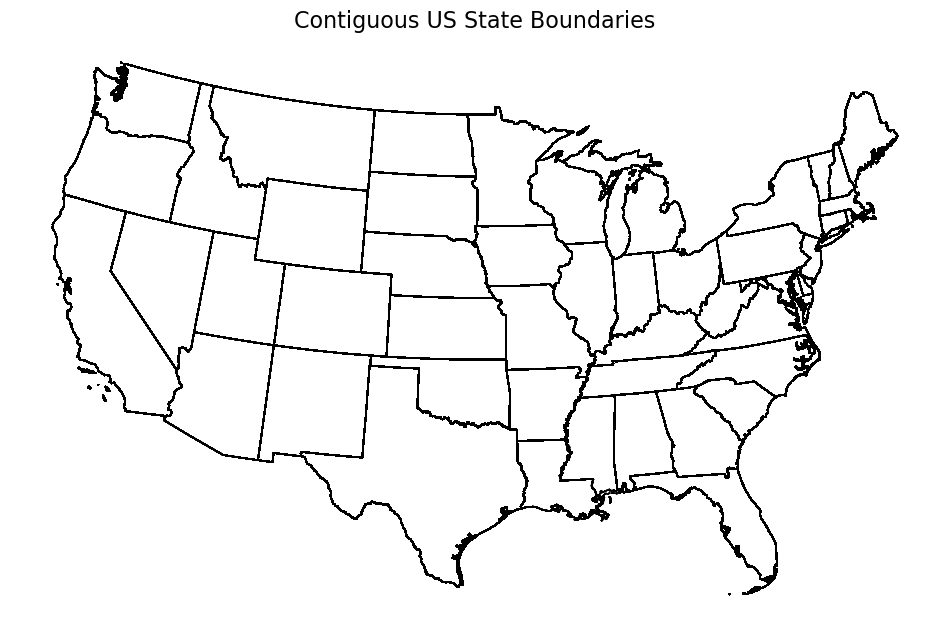

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
states.boundary.plot(ax=ax, linewidth=1.0, color='black')
ax.set_title('Contiguous US State Boundaries', fontsize=16)
ax.axis('off')
plt.savefig('DanielTongu_state_boundaries.png', dpi=300, bbox_inches='tight')
plt.show()


# Tornado Distribution Map

**Purpose and Rationale**  
Visualizes both location and intensity of tornado events across the continental US.

**Big Takeaway**  
Reveals geographic patterns in tornado occurrence and severity.

**What the Visualization Shows**  
- Each point represents a tornado event  
- Color indicates EF-scale magnitude  
- Underlying state boundaries for context  

**Highlight**  
Color-coding makes intensity differences immediately visible while showing spatial distribution.

**Key Insights**  
- Identifies potential "tornado alley" regions  
- Shows how tornado intensity varies geographically  

**Why This Matters**  
Understanding spatial patterns helps in emergency preparedness planning.


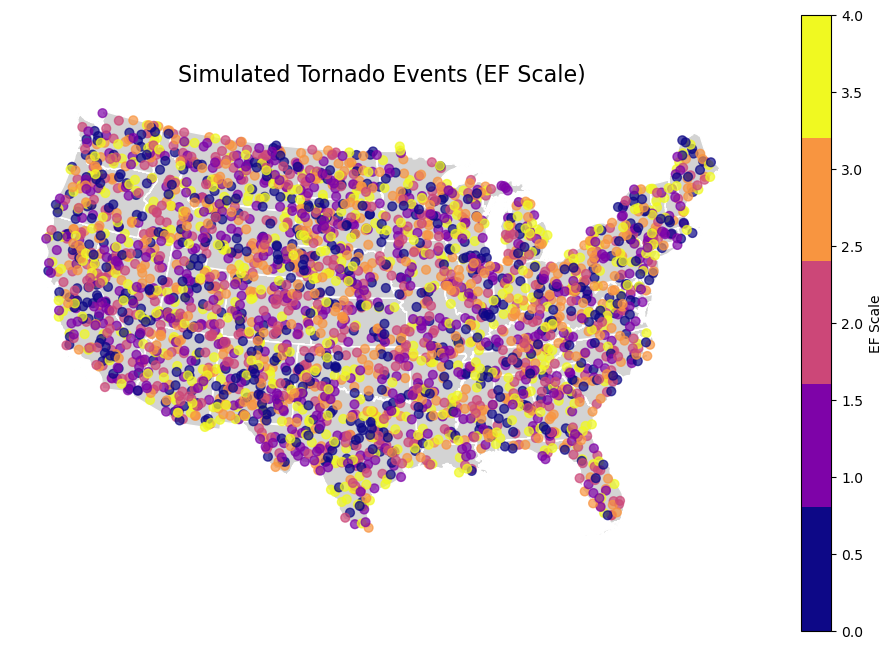

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))
# Draw base map
states.plot(ax=ax, color='lightgray', edgecolor='white')
# Create discrete colormap for EF scale
base_cmap = plt.get_cmap('plasma', 5)
tornadoes.plot(
    ax=ax,
    column='magnitude',
    cmap=base_cmap,
    markersize=40,
    alpha=0.7,
    legend=True,
    legend_kwds={'label': 'EF Scale'}
)
ax.set_title('Simulated Tornado Events (EF Scale)', fontsize=16)
ax.axis('off')
plt.savefig('DanielTongu_tornado_points.png', dpi=300, bbox_inches='tight')
plt.show()


# Tornado Count by State

**Purpose and Rationale**  
Quantifies and compares tornado frequency across different states.

**Big Takeaway**  
Some states experience significantly more tornadoes than others.

**What the Visualization Shows**  
- States ranked by tornado count  
- Bar heights represent total occurrences  
- Direct state-to-state comparisons  

**Highlight**  
Descending order makes high-frequency states immediately apparent.

**Key Insights**  
- Identifies most tornado-prone states  
- Enables relative risk comparisons  

**Why This Matters**  
Helps prioritize resources for tornado preparedness and response.


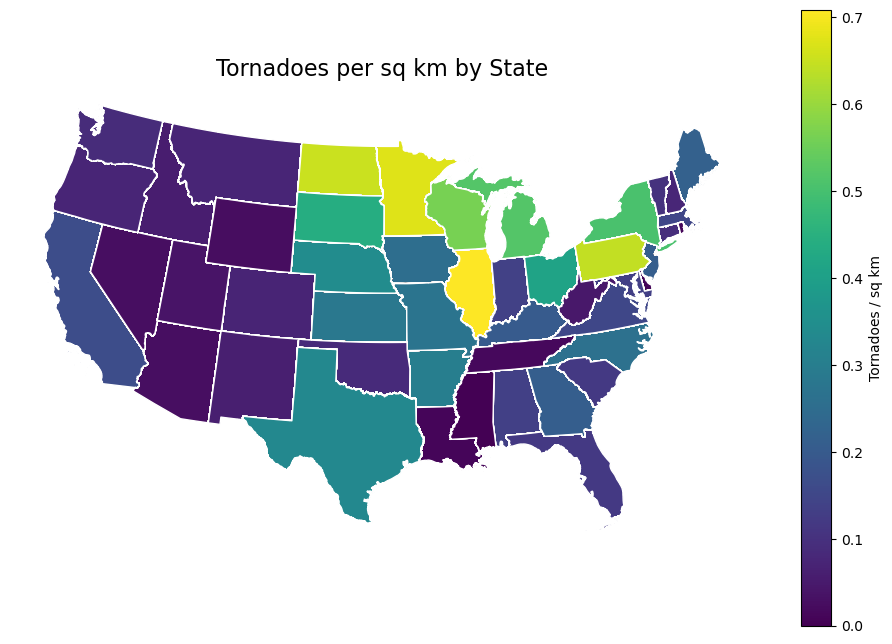

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
# Use per-capita or per-area normalization already computed
states.plot(
    column='tornado_per_sqkm',
    ax=ax,
    cmap='viridis',
    edgecolor='white',
    legend=True,
    legend_kwds={'label': 'Tornadoes / sq km'}
)
ax.set_title('Tornadoes per sq km by State', fontsize=16)
ax.axis('off')
plt.savefig('DanielTongu_choropleth.png', dpi=300, bbox_inches='tight')
plt.show()


# Monthly Distribution of Tornadoes

**Purpose and Rationale**  
Examines seasonal patterns in tornado occurrence.

**Big Takeaway**  
Tornado frequency follows distinct seasonal patterns.

**What the Visualization Shows**  
- Monthly tornado counts across a year  
- Line graph showing trends over time  
- Peak and off-peak periods  

**Highlight**  
Clearly shows when tornado season peaks occur.

**Key Insights**  
- Identifies highest-risk months  
- Shows seasonal variations in frequency  

**Why This Matters**  
Helps time preparedness activities and warning systems effectively.


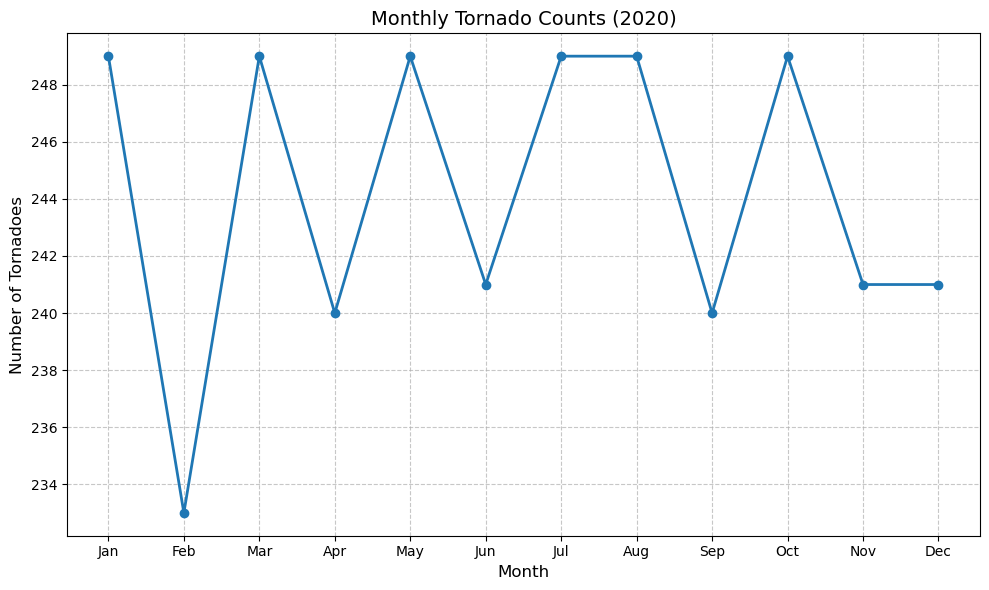

In [10]:
monthly_counts = tornadoes['month'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    monthly_counts.index,
    monthly_counts.values,
    marker='o',
    linewidth=2
)
ax.set_title('Monthly Tornado Counts (2020)', fontsize=14)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Number of Tornadoes', fontsize=12)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('DanielTongu_tornado_by_month.png', dpi=300, bbox_inches='tight')
plt.show()


# Tornado Magnitude Distribution

**Purpose and Rationale**  
Analyzes frequency of different tornado intensity levels.

**Big Takeaway**  
Weak tornadoes are far more common than strong ones.

**What the Visualization Shows**  
- EF-scale ratings on x-axis  
- Count of tornadoes at each intensity level  
- Color-coded by magnitude  

**Highlight**  
Dramatic drop-off in frequency as intensity increases.

**Key Insights**  
- Most tornadoes are EF0-EF1  
- Strong tornadoes are rare but impactful  

**Why This Matters**  
Helps communities prepare for most likely scenarios.


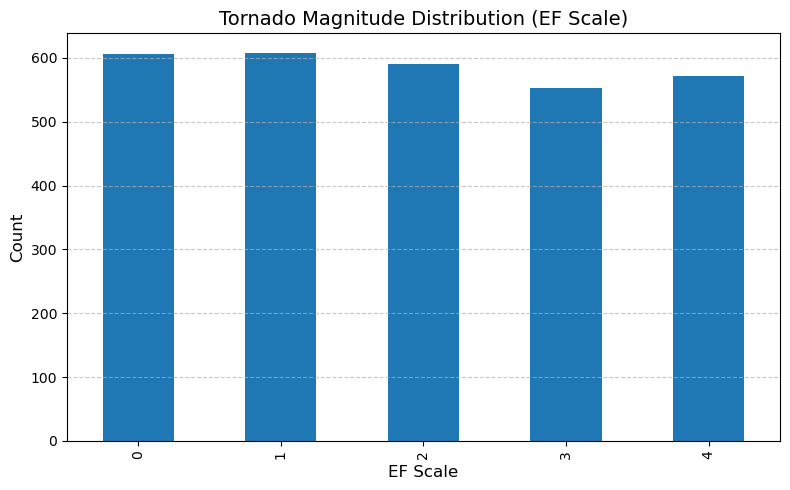

In [12]:
mag_counts = tornadoes['magnitude'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(8, 5))
mag_counts.plot(kind='bar', ax=ax)
ax.set_title('Tornado Magnitude Distribution (EF Scale)', fontsize=14)
ax.set_xlabel('EF Scale', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('DanielTongu_magnitude_dist.png', dpi=300, bbox_inches='tight')
plt.show()


# Tornado Density Heatmap

**Purpose and Rationale**  
Identifies concentrated areas of tornado activity.

**Big Takeaway**  
Tornado occurrences cluster in specific regions.

**What the Visualization Shows**  
- Geographic heatmap overlay  
- Warmer colors indicate higher density  
- Point locations for reference  

**Highlight**  
Clearly visualizes tornado hotspots.

**Key Insights**  
- Reveals regional risk patterns  
- Shows clustering beyond state boundaries  

**Why This Matters**  
Identifies areas needing special building codes or warning systems.


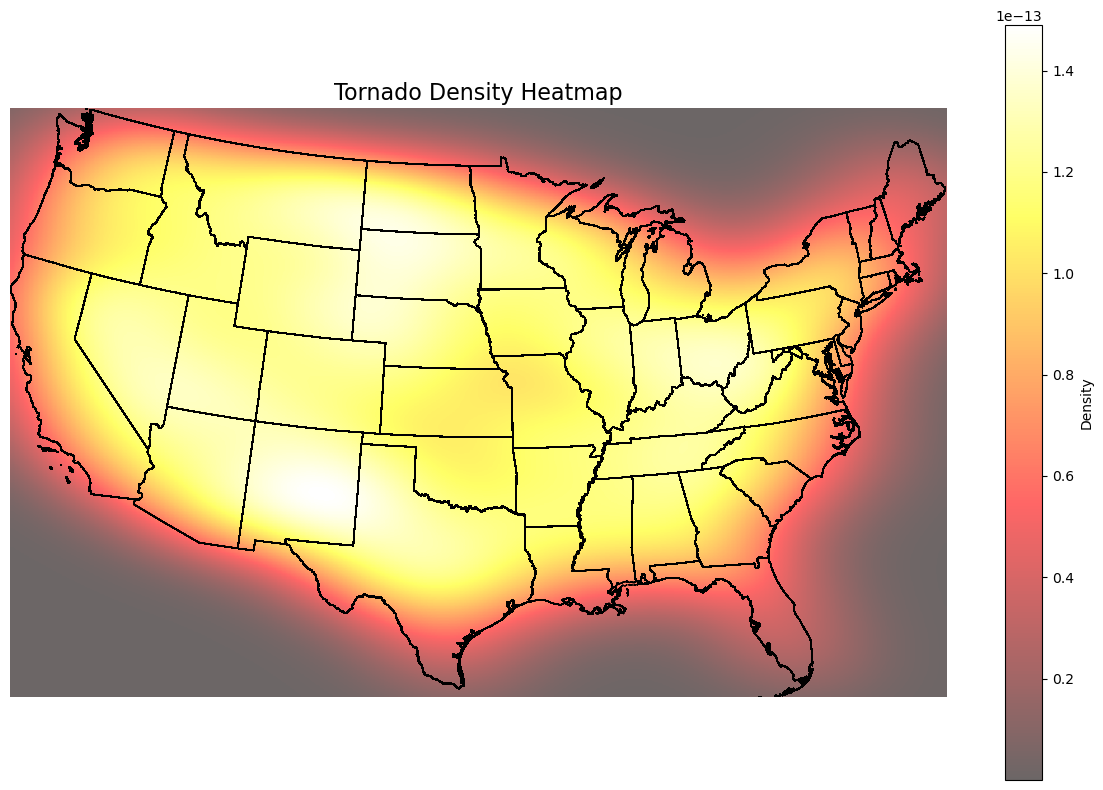

In [14]:
from scipy.stats import gaussian_kde

# Prepare grid for KDE
points = np.vstack([tornadoes.geometry.x, tornadoes.geometry.y]).T
kde = gaussian_kde(points.T)
minx, miny, maxx, maxy = states.total_bounds
xgrid = np.linspace(minx, maxx, 200)
ygrid = np.linspace(miny, maxy, 200)
X, Y = np.meshgrid(xgrid, ygrid)
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

fig, ax = plt.subplots(figsize=(12, 8))
# Plot heatmap first
im = ax.imshow(
    Z,
    origin='lower',
    extent=[minx, maxx, miny, maxy],
    cmap='hot',
    alpha=0.6,
    zorder=1
)
# Overlay state boundaries
states.plot(ax=ax, color='none', edgecolor='black', linewidth=0.8, zorder=2)
fig.colorbar(im, ax=ax, label='Density')
ax.set_title('Tornado Density Heatmap', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.savefig('DanielTongu_kde_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


# State-Level Tornado Frequency per Area

**Purpose and Rationale**  
Normalizes tornado counts by state area for fair comparison.

**Big Takeaway**  
Some smaller states have high tornado density despite low total counts.

**What the Visualization Shows**  
- Choropleth map colored by tornadoes/sq km  
- Normalized view of tornado risk  
- Geographic patterns  

**Highlight**  
Reveals risk patterns obscured by raw counts.

**Key Insights**  
- Provides more accurate risk assessment  
- Accounts for state size differences  

**Why This Matters**  
Gives residents better understanding of relative tornado risk.


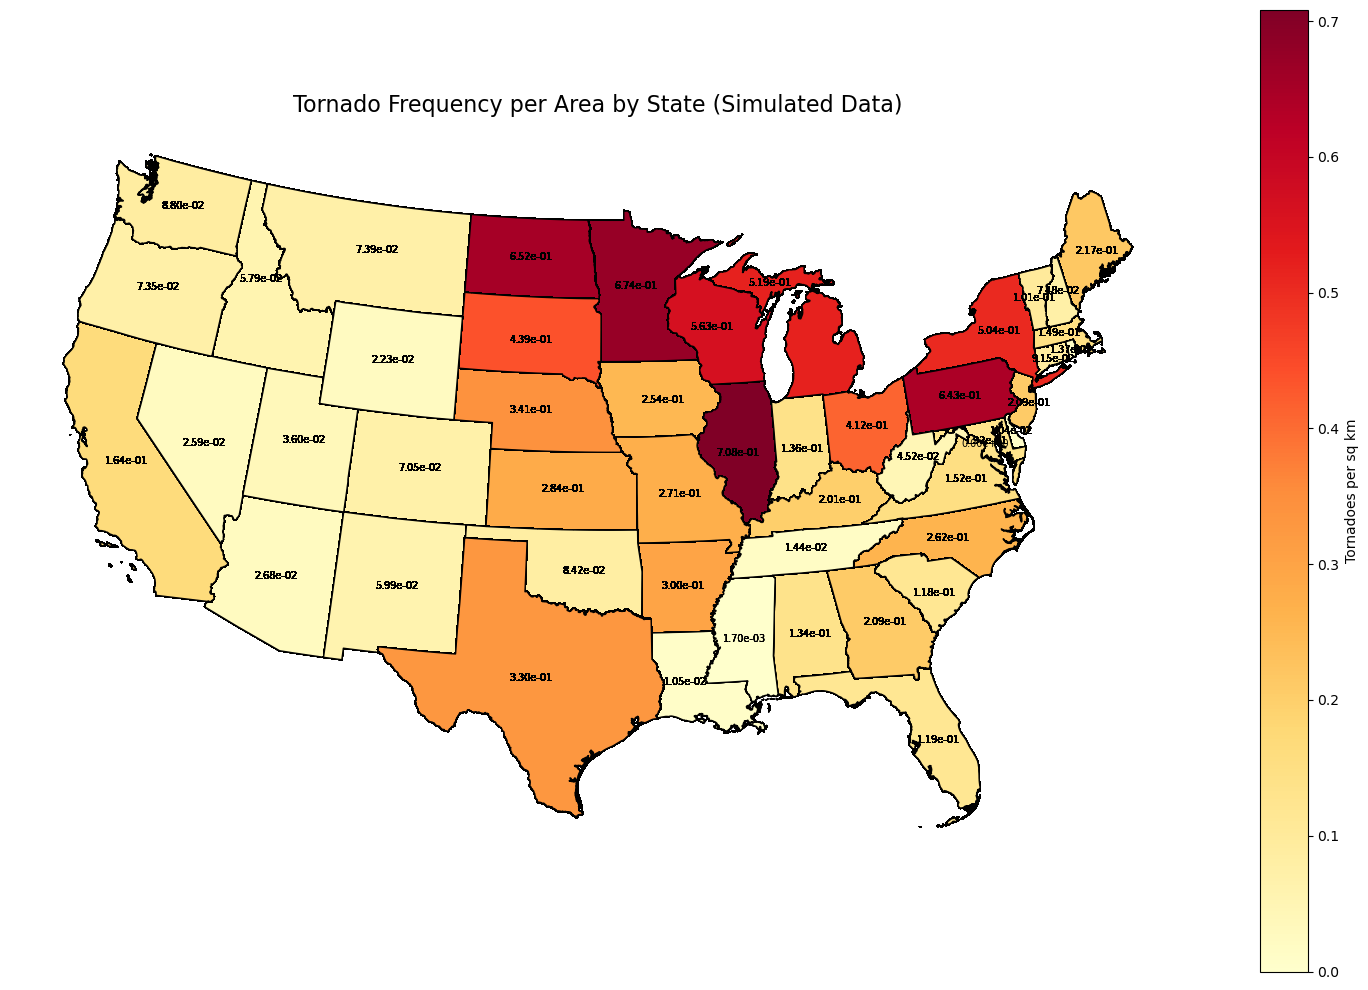

In [16]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 10))

# Plot choropleth with appropriate normalization
vmin = states['tornado_per_sqkm'].min()
vmax = states['tornado_per_sqkm'].max()
norm = plt.Normalize(vmin=vmin, vmax=vmax)

states.plot(
    column='tornado_per_sqkm',
    ax=ax,
    legend=True,
    cmap='YlOrRd',
    edgecolor='black',
    norm=norm,
    legend_kwds={'label': 'Tornadoes per sq km'}
)

# Annotate each state at its representative point
for _, row in states.iterrows():
    point = row['geometry'].representative_point()
    x, y = point.x, point.y
    label = f"{row['tornado_per_sqkm']:.2e}"  # scientific notation for clarity
    ax.text(x, y, label, ha='center', va='center', fontsize=7)

# Remove axes and set title
ax.set_axis_off()
ax.set_title('Tornado Frequency per Area by State (Simulated Data)', fontsize=16)

# Save figure if specified
plt.savefig('DanielTongu_TornadoDensityByState.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()